In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [27]:
# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")

print("="*60)
print("PREPROCESAMIENTO DE DATOS - AGRICULTURA VERTICAL")
print("="*60)

PREPROCESAMIENTO DE DATOS - AGRICULTURA VERTICAL


1. CARGA DE DATOS

In [28]:
print("\n1. CARGANDO DATOS...")
df = pd.read_csv('../data/raw/agricultura_vertical_dataset.csv')

print(f"Shape original: {df.shape}")
print(f"Columnas: {list(df.columns)}")

# Copia para comparaciones
df_original = df.copy()


1. CARGANDO DATOS...
Shape original: (50000, 26)
Columnas: ['timestamp', 'hora_dia', 'dia_semana', 'estacion', 'temperatura_c', 'humedad_rel_pct', 'co2_ppm', 'vpd_kpa', 'pm2_5_ugm3', 'pm10_ugm3', 'vocs_mgm3', 'no2_ugm3', 'o3_ugm3', 'aqi_indice', 'par_umol_m2_s', 'ppfd_umol_m2_s', 'fotoluminiscencia_intensidad', 'espectro_pico_nm', 'eficiencia_fotosintetica_pct', 'ajuste_temp_c', 'ajuste_humedad_pct', 'ajuste_co2_ppm', 'ajuste_par_umol', 'purificacion_requerida_pct', 'condiciones_categoria', 'calidad_aire_categoria']


2. ANÁLISIS DE CALIDAD DE DATOS

In [29]:
print("\n2. ANALISIS DE CALIDAD DE DATOS...")

def analyze_data_quality(df):
    """Análisis completo de calidad de datos"""
    quality_report = pd.DataFrame({
        'Column': df.columns,
        'Dtype': df.dtypes,
        'Non_Null_Count': df.count(),
        'Null_Count': df.isnull().sum(),
        'Null_Percentage': (df.isnull().sum() / len(df)) * 100,
        'Unique_Count': df.nunique(),
        'Duplicate_Rows': len(df) - len(df.drop_duplicates())
    })

    return quality_report

quality_report = analyze_data_quality(df)
print("\nREPORTE DE CALIDAD:")
print(quality_report)

# Verificar duplicados
duplicates = df.duplicated().sum()
print(f"\nFilas duplicadas: {duplicates}")

if duplicates > 0:
    print("Eliminando duplicados...")
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Shape después de eliminar duplicados: {df.shape}")



2. ANALISIS DE CALIDAD DE DATOS...

REPORTE DE CALIDAD:
                                                    Column    Dtype  \
timestamp                                        timestamp   object   
hora_dia                                          hora_dia    int64   
dia_semana                                      dia_semana    int64   
estacion                                          estacion   object   
temperatura_c                                temperatura_c  float64   
humedad_rel_pct                            humedad_rel_pct  float64   
co2_ppm                                            co2_ppm  float64   
vpd_kpa                                            vpd_kpa  float64   
pm2_5_ugm3                                      pm2_5_ugm3  float64   
pm10_ugm3                                        pm10_ugm3  float64   
vocs_mgm3                                        vocs_mgm3  float64   
no2_ugm3                                          no2_ugm3  float64   
o3_ugm3             

3. MANEJO DE VALORES FALTANTES

In [30]:
# ============================================================================
# 3. MANEJO DE VALORES FALTANTES
# ============================================================================

print("\n3. MANEJO DE VALORES FALTANTES...")

# Identificar patrones de valores faltantes
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_percentage
}).sort_values('Missing_Percentage', ascending=False)

print("\nVALORES FALTANTES POR COLUMNA:")
print(missing_df[missing_df['Missing_Count'] > 0])

# Estrategias de imputación
def handle_missing_values(df):
    """Manejo inteligente de valores faltantes"""
    df_processed = df.copy()

    # Para variables numéricas - usar mediana (más robusta a outliers)
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        if df_processed[col].isnull().sum() > 0:
            median_value = df_processed[col].median()
            df_processed[col].fillna(median_value, inplace=True)
            print(f"  - {col}: {df[col].isnull().sum()} valores imputados con mediana {median_value:.2f}")

    # Para variables categóricas - usar moda
    categorical_cols = df_processed.select_dtypes(include=['object']).columns

    for col in categorical_cols:
        if df_processed[col].isnull().sum() > 0:
            mode_value = df_processed[col].mode()[0]
            df_processed[col].fillna(mode_value, inplace=True)
            print(f"  - {col}: {df[col].isnull().sum()} valores imputados con moda '{mode_value}'")

    return df_processed

# Aplicar manejo de valores faltantes
if missing_data.sum() > 0:
    df = handle_missing_values(df)
else:
    print("No se encontraron valores faltantes.")



3. MANEJO DE VALORES FALTANTES...

VALORES FALTANTES POR COLUMNA:
                        Missing_Count  Missing_Percentage
calidad_aire_categoria             44               0.088
  - calidad_aire_categoria: 44 valores imputados con moda 'Regular'


4. DETECCIÓN Y MANEJO DE OUTLIERS


4. DETECCION Y MANEJO DE OUTLIERS...

OUTLIERS DETECTADOS:
  - humedad_rel_pct: 162 outliers (0.3%)
    Rango normal: [41.10, 94.97]
  - co2_ppm: 152 outliers (0.3%)
    Rango normal: [260.76, 1340.53]
  - par_umol_m2_s: 172 outliers (0.3%)
    Rango normal: [72.79, 725.92]
  - pm2_5_ugm3: 166 outliers (0.3%)
    Rango normal: [-4.17, 28.15]
  - vocs_mgm3: 204 outliers (0.4%)
    Rango normal: [-0.22, 0.83]
  - aqi_indice: 166 outliers (0.3%)
    Rango normal: [6.07, 86.78]
  - vpd_kpa: 655 outliers (1.3%)
    Rango normal: [0.02, 1.67]
  - eficiencia_fotosintetica_pct: 329 outliers (0.7%)
    Rango normal: [20.82, 71.96]
  - fotoluminiscencia_intensidad: 260 outliers (0.5%)
    Rango normal: [10.12, 71.48]


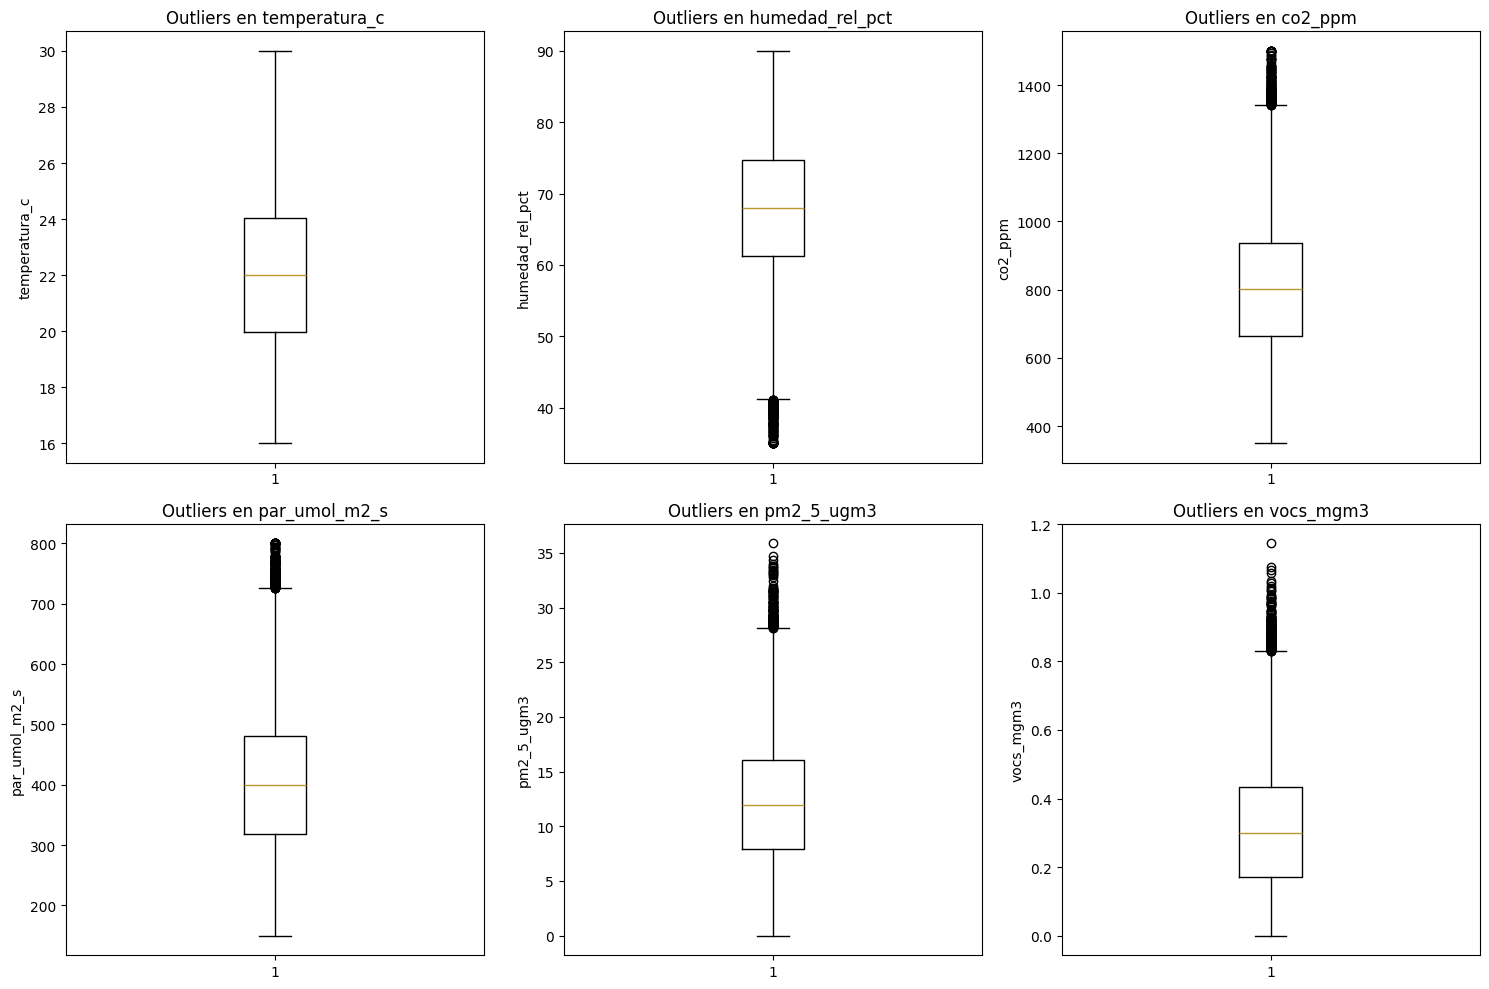


Total outliers extremos eliminados: 0
Shape después de limpieza: (50000, 26)


In [31]:
# ============================================================================
# 4. DETECCIÓN Y MANEJO DE OUTLIERS
# ============================================================================

print("\n4. DETECCION Y MANEJO DE OUTLIERS...")

def detect_outliers_iqr(df, columns):
    """Detectar outliers usando método IQR"""
    outliers_dict = {}

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_dict[col] = {
            'count': len(outliers),
            'percentage': len(outliers) / len(df) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'indices': outliers.index.tolist()
        }

    return outliers_dict

# Variables numéricas principales
numeric_vars = ['temperatura_c', 'humedad_rel_pct', 'co2_ppm', 'par_umol_m2_s',
                'pm2_5_ugm3', 'vocs_mgm3', 'aqi_indice', 'vpd_kpa',
                'eficiencia_fotosintetica_pct', 'fotoluminiscencia_intensidad']

# Detectar outliers
outliers_info = detect_outliers_iqr(df, numeric_vars)

print("\nOUTLIERS DETECTADOS:")
for var, info in outliers_info.items():
    if info['count'] > 0:
        print(f"  - {var}: {info['count']} outliers ({info['percentage']:.1f}%)")
        print(f"    Rango normal: [{info['lower_bound']:.2f}, {info['upper_bound']:.2f}]")

# Visualizar outliers principales
def plot_outliers(df, columns, figsize=(15, 10)):
    """Visualizar outliers con boxplots"""
    n_cols = 3
    n_rows = (len(columns) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1:
        axes = [axes]
    axes = axes.flatten()

    for i, col in enumerate(columns):
        if i < len(axes):
            axes[i].boxplot(df[col].dropna())
            axes[i].set_title(f'Outliers en {col}')
            axes[i].set_ylabel(col)

    # Ocultar ejes vacíos
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

# Mostrar outliers
plot_outliers(df, numeric_vars[:6])  # Primeras 6 variables

# Estrategia de manejo de outliers para agricultura vertical
def handle_agriculture_outliers(df):
    """Manejo específico de outliers para agricultura vertical"""
    df_processed = df.copy()

    # Rangos realistas para agricultura vertical
    realistic_ranges = {
        'temperatura_c': (10, 40),      # Rango físicamente posible
        'humedad_rel_pct': (20, 95),    # Rango de humedad realista
        'co2_ppm': (200, 2000),         # Rango de CO2 realista
        'par_umol_m2_s': (50, 1000),    # Rango de PAR realista
        'pm2_5_ugm3': (0, 100),         # Rango contaminación realista
        'vocs_mgm3': (0, 5),            # Rango VOCs realista
        'aqi_indice': (0, 100),         # Por definición 0-100
        'vpd_kpa': (0.1, 5),            # Rango VPD realista
        'eficiencia_fotosintetica_pct': (0, 100),  # Por definición 0-100
        'fotoluminiscencia_intensidad': (0, 100)   # Escala normalizada
    }

    outliers_removed = 0

    for var, (min_val, max_val) in realistic_ranges.items():
        if var in df_processed.columns:
            # Contar outliers extremos
            extreme_outliers = df_processed[
                (df_processed[var] < min_val) | (df_processed[var] > max_val)
            ]

            if len(extreme_outliers) > 0:
                print(f"  - {var}: Eliminando {len(extreme_outliers)} outliers extremos")
                outliers_removed += len(extreme_outliers)

                # Eliminar outliers extremos
                df_processed = df_processed[
                    (df_processed[var] >= min_val) & (df_processed[var] <= max_val)
                ]

    print(f"\nTotal outliers extremos eliminados: {outliers_removed}")
    print(f"Shape después de limpieza: {df_processed.shape}")

    return df_processed.reset_index(drop=True)

# Aplicar manejo de outliers
df = handle_agriculture_outliers(df)


5. VALIDACIÓN DE RANGOS ESPECÍFICOS

In [32]:
# ============================================================================
# 5. VALIDACIÓN DE RANGOS ESPECÍFICOS
# ============================================================================

print("\n5. VALIDACION DE RANGOS PARA AGRICULTURA VERTICAL...")

def validate_agriculture_ranges(df):
    """Validar que los datos estén en rangos apropiados para agricultura"""

    # Rangos óptimos conocidos para agricultura vertical
    optimal_ranges = {
        'temperatura_c': (18, 28, 'Temperatura fuera de rango óptimo'),
        'humedad_rel_pct': (40, 85, 'Humedad fuera de rango óptimo'),
        'co2_ppm': (350, 1500, 'CO2 fuera de rango típico'),
        'par_umol_m2_s': (150, 800, 'PAR fuera de rango típico'),
        'aqi_indice': (0, 100, 'AQI debe estar entre 0-100')
    }

    validation_report = {}

    for var, (min_opt, max_opt, message) in optimal_ranges.items():
        if var in df.columns:
            out_of_range = df[(df[var] < min_opt) | (df[var] > max_opt)]
            percentage = len(out_of_range) / len(df) * 100

            validation_report[var] = {
                'out_of_range_count': len(out_of_range),
                'out_of_range_percentage': percentage,
                'min_value': df[var].min(),
                'max_value': df[var].max(),
                'optimal_range': f"{min_opt}-{max_opt}"
            }

            if percentage > 0:
                print(f"  - {var}: {percentage:.1f}% fuera de rango óptimo ({min_opt}-{max_opt})")

    return validation_report

validation_report = validate_agriculture_ranges(df)


5. VALIDACION DE RANGOS PARA AGRICULTURA VERTICAL...
  - temperatura_c: 11.4% fuera de rango óptimo (18-28)
  - humedad_rel_pct: 4.8% fuera de rango óptimo (40-85)


6. TRANSFORMACIONES DE DATOS

In [33]:
# ============================================================================
# 6. TRANSFORMACIONES DE DATOS
# ============================================================================

print("\n6. APLICANDO TRANSFORMACIONES DE DATOS...")

def apply_transformations(df):
    """Aplicar transformaciones necesarias"""
    df_transformed = df.copy()

    # Convertir timestamp si existe
    if 'timestamp' in df_transformed.columns:
        df_transformed['timestamp'] = pd.to_datetime(df_transformed['timestamp'])
        print("  - Timestamp convertido a datetime")

    # Crear variables temporales si no existen
    if 'timestamp' in df_transformed.columns:
        if 'hora_dia' not in df_transformed.columns:
            df_transformed['hora_dia'] = df_transformed['timestamp'].dt.hour
        if 'dia_semana' not in df_transformed.columns:
            df_transformed['dia_semana'] = df_transformed['timestamp'].dt.dayofweek
        if 'mes' not in df_transformed.columns:
            df_transformed['mes'] = df_transformed['timestamp'].dt.month
        print("  - Variables temporales extraídas")

    # Asegurar tipos de datos correctos
    numeric_columns = ['temperatura_c', 'humedad_rel_pct', 'co2_ppm', 'par_umol_m2_s',
                      'pm2_5_ugm3', 'vocs_mgm3', 'aqi_indice', 'vpd_kpa',
                      'eficiencia_fotosintetica_pct', 'fotoluminiscencia_intensidad']

    for col in numeric_columns:
        if col in df_transformed.columns:
            df_transformed[col] = pd.to_numeric(df_transformed[col], errors='coerce')

    # Tipos enteros para variables categóricas ordinales
    ordinal_columns = ['hora_dia', 'dia_semana', 'mes']
    for col in ordinal_columns:
        if col in df_transformed.columns:
            df_transformed[col] = df_transformed[col].astype(int)

    print("  - Tipos de datos corregidos")

    return df_transformed

df = apply_transformations(df)


6. APLICANDO TRANSFORMACIONES DE DATOS...
  - Timestamp convertido a datetime
  - Variables temporales extraídas
  - Tipos de datos corregidos
